[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kuvychko/numeric_exploration/main?labpath=logistic_map.ipynb)

# Logistic map (quadratic iterator)

Author: [Igor V. Kuvychko](https://www.linkedin.com/in/igor-kuvychko/)  
Date: 10/13/2023


[Logistic map](https://en.wikipedia.org/wiki/Logistic_map) (quadratic iterator) in an archetypal example of complex (chaotic) behavior arising in a simple system. It can also serve as a very simple animal population model.

* The map is defined as a recurrence relationship:

$$x_{n+1} = a x_{n} (1 - x_n)$$

where $x_n \in [0, 1]$ and $a \in [0, 4]$. Value $x_n$ represents the fraction of the environment carrying capacity (the ratio of existing population to the maximum possible population). This equation is intended to capture two effects:

* reproduction $x_n$ (proportionate to the size of the current generation)
* starvation $1 - x_n$

The map displays several kinds of behavior depending on the values of $a$ and $x_0$:

* If $a \in [0, 1]$, then $x_n$ always tends to zero for any value of $x_0$ (population collapse).
* If $a \in (1, 2)$, then all initial populations $x_0$ (except 0 and 1) converge to $\frac{a-1}{a}$ (single attracting point).
* If $a = 2$, then $x_n$ converges to $\frac{1}{2}$ (maximum of the logistic map).
* If $a \in (2, 3)$, then $x_n$ still converges to the single attracting point $\frac{a-1}{a}$, but successive iterations of $x_n$ flip-flop around the limiting value.
* If $a \in [3, 1+\sqrt{6})$, the behavior changes, the population $x_n$ oscillates around the two attracting points.
* As $a$ increases further, the number of attracting points double, until at $a ≈ 3.56995$ truly chaotic behavior emerges for almost all initial populations $x_0$. Well-defined oscillations disappear, and tiny variations in the initial population leads to dramatically different results over time - a prime characteristic of chaos.

This notebook explores this behavior numerically.

## Python notes

* impyl dependency and a corresponding magic command `%matplotlib ipympl` is needed to make matplotlib, ipywidgets, and matplotlib animation play nice both in a local session and when running this notebook in [Binder](https://mybinder.org/). 
    * If ipywidgets and matplotlib animation do not show in a local session, try this magic command instead: `%matplotlib notebook`. Or better yet,     update your jupyter and run this notebook in Jupyter Lab.
    * By default, ipyml shows headers with figure numbers for each matplotlib plot (highly annoying). It is turned off for each plot individually using `fig.canvas.header_visible = False` as I was not able to figure out how to do it at a notebook level. See [ipyml documentation](https://matplotlib.org/ipympl/examples/full-example.html) for more details.
* ipywidgets widget with multiple tabs and selector types
* Matplotlib animation function serves as an example of using multiple Artists with FuncAnimation
* Parameter $a$ is meshed using a variable spacing to better show the behavior of the logistic map in the "interesting" region.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import ipywidgets as widgets
from ipywidgets import interactive

%matplotlib ipympl

## Orbit plot

In [2]:
def quadratic_iterator(n_iterations, x_naught, a, threshold=False):
    """
    Generate array of succesive quadratic iterator values.
    
    threshold=True enables convergence detection for performance optimization,
    helpful when building Feigenbaum maps.
    """
    counter=0
    orbit=[x_naught]
    iterator = lambda x: a*x*(1-x)
    while counter < n_iterations:
        counter += 1
        new_orbit = iterator(orbit[-1])
        if threshold & (abs(orbit[-1] - new_orbit) < 1E-8):
            break
        orbit.append(new_orbit)        
    return orbit

def orbit_plot(n_iterations, x_naught, a):
    "Plots quadratic iterator values vs iteration count"
    y_axis = quadratic_iterator(n_iterations, x_naught, a)
    fig, ax = plt.subplots(figsize=(8, 3))
    fig.canvas.header_visible = False
    ax.plot(y_axis)
    ax.set_title('$x_{n+1} = a x_{n} (1 - x_n)$', fontsize=16)
    ax.set_xlabel('$n$', fontsize=14)
    ax.set_ylabel('$x_n$', fontsize=14)
    ax.set_ylim(bottom=0, top=1)
    ax.set_xlim(left=0, right=n_iterations)
    plt.show()

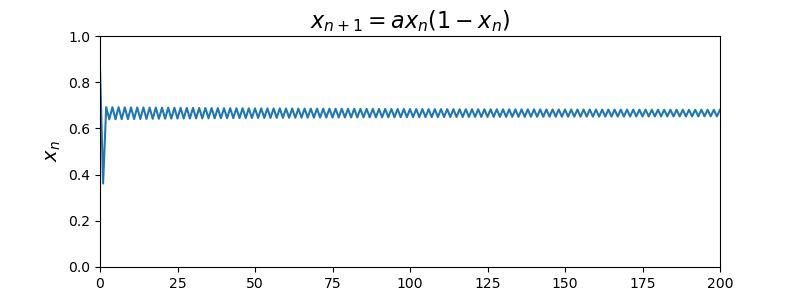

In [3]:
orbit_plot(200, 0.86, 3)

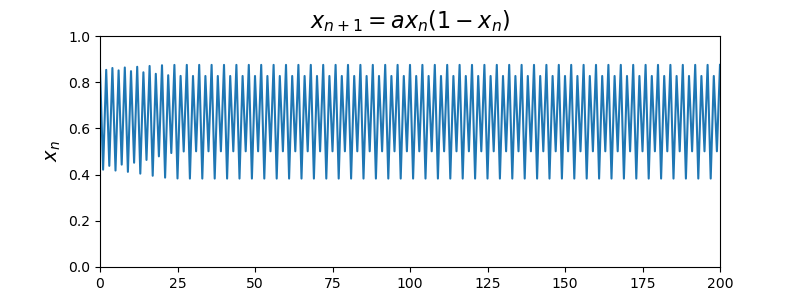

In [4]:
orbit_plot(200, 0.86, 3.5)

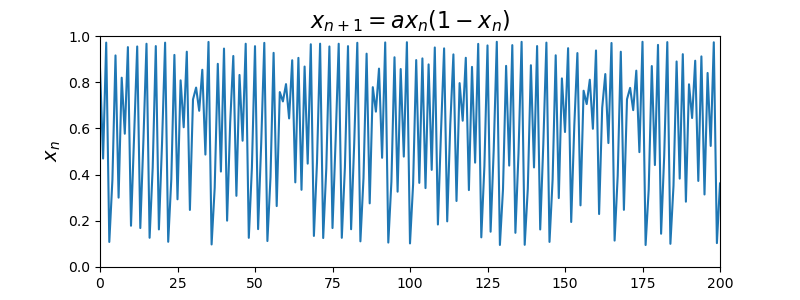

In [5]:
orbit_plot(200, 0.86, 3.9)

## Cobweb plot

In [6]:
def iterator_path(orbit):
    "Generate iterator path for cobweb plot"
    x_out = [orbit[0]]
    y_out = [0]
    for i in range(len(orbit)-1):
        x_out.extend([orbit[i], orbit[i+1]])
        y_out.extend([orbit[i+1], orbit[i+1]])
    return {'x': x_out, 'y': y_out}

def quadratic_func(n_iterations, x_naught, a):
    "Generate x,y arrays for a plot of the quadratic function"
    iterator = lambda x: a*x*(1-x)
    x_axis = np.linspace(0, 1, 100)
    y_axis = iterator(x_axis)
    return {'x': x_axis, 'y': y_axis}

def cobweb_plot(n_iterations, x_naught, a):
    "Cobweb plot"
    orbit = quadratic_iterator(n_iterations, x_naught, a)
    path = iterator_path(orbit)
    fig, ax = plt.subplots(figsize=(6, 5.5))
    fig.canvas.header_visible = False
    ax.set_xlabel('$x_n$', fontsize=14)
    ax.set_ylabel('$x_{n+1}$', fontsize=14)
    ax.plot(path['x'], path['y'], linewidth=0.5, color='r')
    quad_func = quadratic_func(n_iterations, x_naught, a)
    ax.plot(quad_func['x'], quad_func['y'], color='b')
    ax.plot([0, 1], [0, 1], color='g')
    ax.set_title('Cobweb plot', fontsize=16)
    ax.set_ylim(bottom=0, top=1)
    ax.set_xlim(left=0, right=1)
    plt.show()

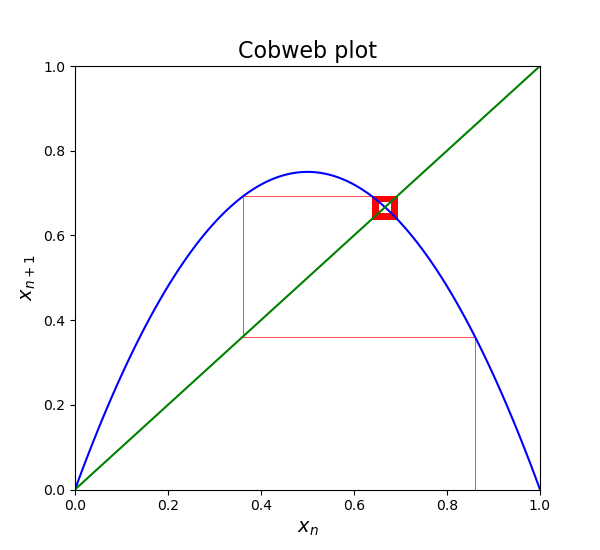

In [7]:
cobweb_plot(200, 0.86, 3)

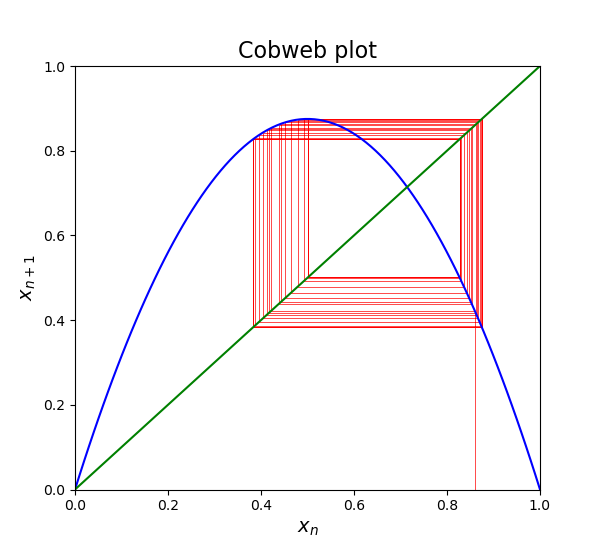

In [8]:
cobweb_plot(500, 0.86, 3.5)

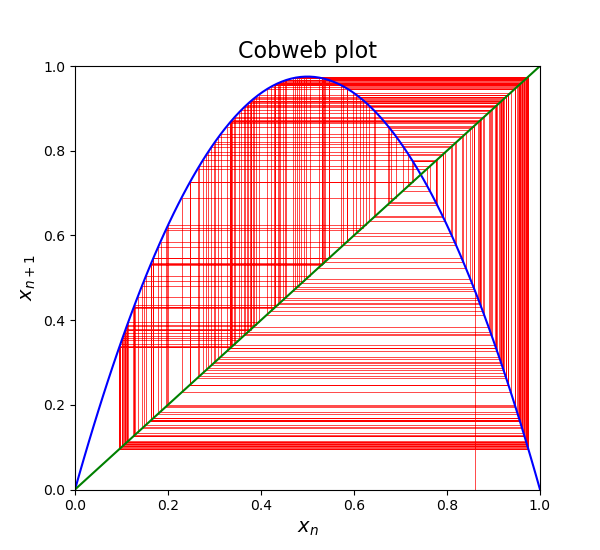

In [9]:
cobweb_plot(200, 0.86, 3.9)

## Sensitivity plot

Explore how a small change in the initial conditions propargates through $x_n$ by plotting a delta between two $x_n$ series for $x_0$ and $x_0 + error$ initial populations.

In [10]:
def sensitivity_plot(n_iterations, x_naught, x_delta, a):
    if (x_naught + x_delta) > 1:
        x_naught -= x_delta #wraparound of x delta    
    iter_one = np.array(quadratic_iterator(n_iterations, x_naught, a, threshold=False))
    iter_two = np.array(quadratic_iterator(n_iterations, x_naught+x_delta, a, threshold=False))
    delta = iter_one - iter_two
    fig, ax = plt.subplots(figsize=(7,3))
    fig.canvas.header_visible = False
    ax.plot(delta)
    ax.set_title('Error propargation plot')
    ax.set_xlabel('$n$')
    ax.set_ylabel('Error')
    ax.set_ylim(bottom=-1, top=1)
    ax.set_xlim(left=0, right=n_iterations)
    plt.show()

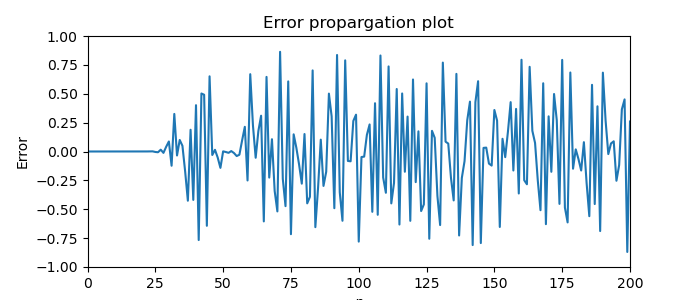

In [11]:
sensitivity_plot(200, 0.86, 1E-8, 3.9)

## Bifuraction diagram (Feigenbaum map)
* Visualization of long-term behavior of $x_n$ series vs. $a$ parameter value
* Last 3/4 of the series data is used to generate the map to simulate long-term behavior

In [12]:
def bifurcation_dict(x_naught, scale=[0,4], start_stop=[50, 250], resolution=200):
    'generate dictionary of long-term behavior of quadratic iterator for Feigenbaum map'
    a_range = [scale[0] + (scale[1] - scale[0])/resolution*i for i in range(resolution)]
    a_list = []
    xinf_list = []
    for i in a_range:
        iterator = quadratic_iterator(start_stop[1], x_naught, i, threshold=True)
        size = len(iterator)
        if size < start_stop[0]:
            xinf_list.append(iterator[-1])
            a_list.append(i)   
        else:
            xinf_list.extend(iterator[start_stop[0]:])
            a_list.extend([i]*(size - start_stop[0]))
    return {'a': a_list, 'x_infinity': xinf_list}

def feigenbaum_map(x_naught, a_scale=[0,4], x_scale=[0,1], depth=200):
    result = bifurcation_dict(x_naught, a_scale, start_stop=[int(depth/4), depth])
    fig, ax = plt.subplots(figsize=(6, 5.5))
    fig.canvas.header_visible = False
    assert len(result['a']) == len(result['x_infinity'])
    ax.scatter(np.array(result['a']), np.array(result['x_infinity']), s=0.25)
    ax.set_title('Feigenbaum map', fontsize=16)
    ax.set_xlabel('$a$', fontsize=14)
    ax.set_ylabel('$x_\inf$', fontsize=14)
    ax.set_xlim(left=a_scale[0], right=a_scale[1])
    ax.set_ylim(bottom=x_scale[0], top=x_scale[1])
    plt.show()

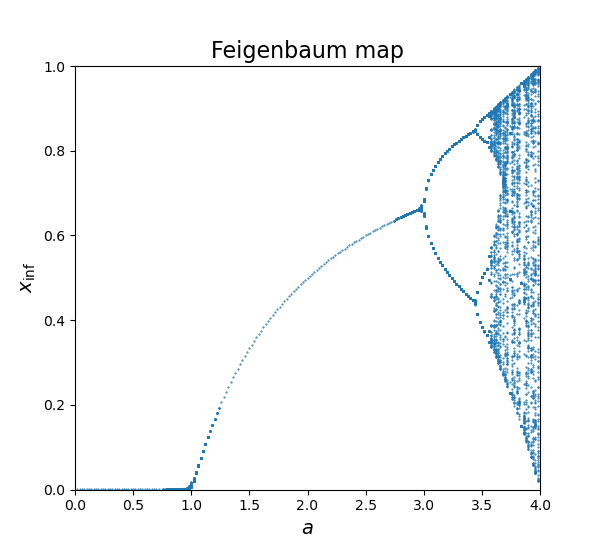

In [13]:
feigenbaum_map(0.86)

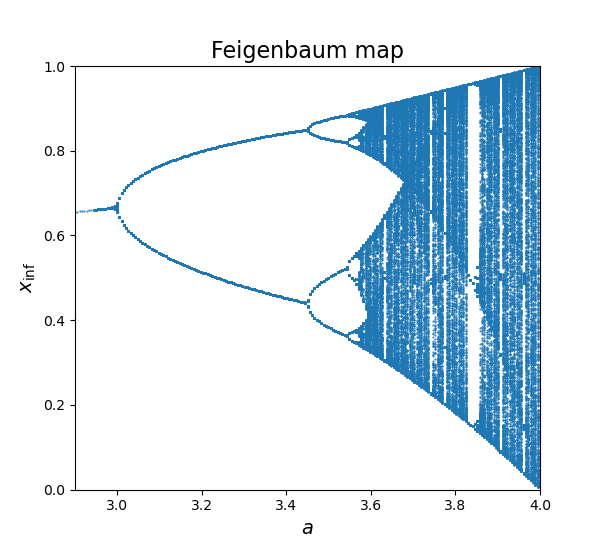

In [14]:
feigenbaum_map(0.86, [2.9, 4], depth=1000)

## Interactive widget

Putting it all together

In [15]:
#widget definitions

def plot_selector(func, n_iterations, x_naught, a):
    return func(n_iterations, x_naught, a)

func_dropdown = widgets.Dropdown(
    options=[('Cobweb plot', cobweb_plot),
        ('Orbit plot', orbit_plot)],
    index=0, description='Function')

iteration_slider = widgets.IntSlider(
    value=100, min=20, max=500, step=20,
    description='iterations',
    continuous_update=False)

iteration_slider_error = widgets.IntSlider(
    value=10, min=5, max=100, step=5,
    description='iterations',
    continuous_update=False)

x_slider = widgets.FloatSlider(
    value=0.1, min=0, max=1, step=0.0001,
    description='X naught',
    continuous_update=False)

a_slider = widgets.FloatSlider(
    value=3, min=0, max=4, step=0.001,
    description='a',
    continuous_update=False)

delta_slider = widgets.FloatLogSlider(
    value=0.5, min=-15, max=-1, step=0.00001,
    description='error',
    continuous_update=False)

a_scale_slider = widgets.FloatRangeSlider(
    value=[0, 4], min=0, max=4, step=0.01, description='a', continuous_update=False)

x_inf_slider = widgets.FloatRangeSlider(
    value=[0, 1], min=0, max=1, step=0.01, description='x infinity', continuous_update=False)

depth_slider = widgets.IntSlider(
    value=200, min=100, max=2000, step=25, description='iterations', continuous_update=False)

widget_orbits = interactive(plot_selector, func=func_dropdown, n_iterations=iteration_slider, x_naught=x_slider, a=a_slider)

widget_sensitivity = interactive(sensitivity_plot, n_iterations=iteration_slider_error, x_naught=x_slider, x_delta=delta_slider,
                                 a=a_slider)
widget_feigenbaum = interactive(feigenbaum_map, x_naught=x_slider, a_scale=a_scale_slider, x_scale=x_inf_slider,
                               depth = depth_slider)

tab_contents = ['Cobweb & orbit plots', 'Error propargation', 'Feigenbaum map']
children = [widget_orbits, widget_sensitivity, widget_feigenbaum]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, tab_contents[i])

In [16]:
# you need to run this cell to see the interactive widget - it does not show in GitHub preview 
tab

## Exploring effect of $a$ parameter via animated cobweb plot

In [17]:
def generate_mesh(knots=[0, 2, 3, 3.45, 3.57, 4], initial_spacing=0.1, scalers=[1,2,4,10,40]):
    "Create an array with increasingly dense points for better animation"

    arrays = []
    for x0, x1, scaler in zip(knots[:-1], knots[1:], scalers):
        num = int((x1 - x0) / (initial_spacing/scaler))
        arrays.append(np.linspace(x0, x1, num, endpoint=False))
    return np.concatenate(arrays)           

In [18]:
def animate_cobweb(x_naught, a_scale=None, frames=100, n_iterations=400, interval=100, file=None):
    """
    if a_scale=None, then parameter a is iterated over a mesh with varying point density 
    to better show interesting regions of the iterator (output of 'generate_mesh' function).
    if a_scale=[a0, a1], then parameter a is iterated over this interval split by the number of frames.
    """
    
    fig, ax = plt.subplots(figsize=(6, 5.5))
    fig.canvas.header_visible = False
    ax.plot([0, 1], [0, 1], color='g')
    ax.set_title('$x_{n+1} = a x_{n} (1 - x_n)$', fontsize=14)
    ax.set_ylim(bottom=0, top=1)
    ax.set_xlim(left=0, right=1)
    ax.set_xlabel('$x_n$', fontsize=14)
    ax.set_ylabel('$x_{n+1}$', fontsize=14)
    
    
    if a_scale is None:
        # creating a mesh with variable point spacing
        a_array = generate_mesh()
    else:
        a_array = np.linspace(a_scale[0], a_scale[1], frames)
    
    # textbox properties
    props = dict(boxstyle='round', alpha=1, color='wheat')

    # setting initial state
    line0, = ax.plot([], [], linewidth=0.5, color='r') 
    line1, = ax.plot([], [], color='b')
    msg = "$x_0 = $" + f"{x_naught:.3f}" + "\n$a = $" + f"{a_array[0]:.3f}"
    box = fig.text(0.05, 0.95, msg, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
 
    def init():
        line0.set_data([], [])
        line1.set_data([], [])
        box = fig.text(0.05, 0.95, msg, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        return line0, line1, box

    def animate(a):
        orbit = quadratic_iterator(n_iterations, x_naught, a)
        path = iterator_path(orbit)
        line0.set_data(path['x'], path['y'])
        quad_func = quadratic_func(n_iterations, x_naught, a)
        line1.set_data(quad_func['x'], quad_func['y'])
        msg = "$x_0 = $" + f"{x_naught:.3f}" + "\n$a = $" + f"{a:.3f}"
        box = fig.text(0.05, 0.95, msg, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        return line0, line1, box

    anim = animation.FuncAnimation(
        fig, animate, init_func = init, frames = a_array,
        interval = interval, blit = True)

    if file:
        anim.save(file)
        
    return anim

MovieWriter ffmpeg unavailable; using Pillow instead.


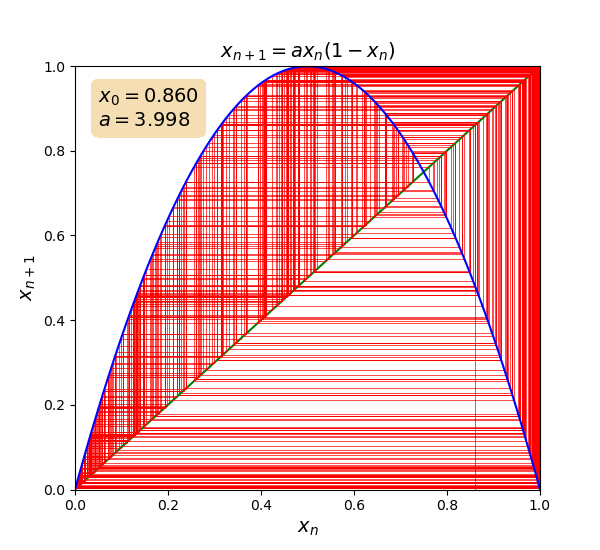

In [19]:
anim = animate_cobweb(0.86, file='quadratic_iterator.gif')